# TPT pipeline with ERA5 and S2S

In [5]:
import sys
sys.path.append("../..")

In [6]:
import numpy as np
from numpy.random import default_rng
import pandas
import matplotlib
from matplotlib import ticker
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import xarray as xr
import netCDF4 as nc
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs
from scipy.stats import genextreme,binom
import functools

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%aimport xr_utils
%aimport feature_template
%aimport feature_stratosphere
%aimport tpt_utils
%aimport tdmc_obj

In [9]:
%matplotlib inline

In [10]:
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

# Set up experiment

Which tasks to do

In [11]:
compute_all_features_flag =           0 # 
assemble_tpt_features_flag =          0
path_counting_flag =                  0
build_msm_flag =                      0
dga_flag =                            0
tune_hyperparameters_flag =           0
regress_over_features_flag =          0
bootstrap_flag =                      0
plot_2d_images =                      0
featset =                             1 # n, where this is the n'th set of features we've tried

In [12]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "e5": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-09-03"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-10-15"),
                #"filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-10-15",),
                #"filename": "era5_features_tpt.nc",
            }),
        }),
        "s2": dict({
            "traj": dict({
                "dir": join(topic_dir, "s2s_data", "raw_data", "2022-08-20"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "s2s_data", "stats", "2022-09-04"),
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "s2s_data", "features_all", "2022-10-15"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "s2s_data", "features_tpt", "2022-10-15",),
                "filename": "s2s_features_tpt.nc",
            }),
        })    
    }),
    "results": dict({
        "shared": join(topic_dir, "results", "tpt_quantities", "2022-11-22", "shared"),
        "extval": join(topic_dir, "results", "tpt_quantities", "2022-11-22", "extval"),
        "pathcounting": join(topic_dir, "results", "tpt_quantities", "2022-11-22", "pathcounting"),
        "direct": join(topic_dir, "results", "tpt_quantities", "2022-11-22", "direct"),
        "dga": join(topic_dir, "results", "tpt_quantities", "2022-11-22", "dga"), # Further sub-directories to be specified below 
    })
})
dispdict = dict({
    "e5": dict({
        "color": "dodgerblue",
        "abbrv": "ERA5",
    }),
    "s2": dict({
        "color": "red",
        "abbrv": "S2S",
    }),
    "linear_model": dict({
        "color": "gray",
        "abborv": "Linear model",
    })
})

In [13]:
# Create the directories if they don't exist already

# Data folders
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)

# Results folders
for path in list(filedict["results"].keys()):
    if not exists(path): makedirs(filedict["results"][path], exist_ok=True)

## Read database and compute features. 

In [14]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [15]:
if compute_all_features_flag:
    obs2compute = [
        "time_observable", "ubar_observable",
        "temperature_observable", "heatflux_observable",
        "qbo_observable",
    ]
    for src in ["e5","s2"]:
        obs_dict = dict({obsname: [] for obsname in obs2compute})
        input_dir = filedict["data"][src]["traj"]["dir"]
        input_file_list = [join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".nc")]
        output_dir = filedict["data"][src]["feat_all"]["dir"]
        feat_strat.compute_all_features_nodask(
            src, input_file_list, output_dir, 
            obs2compute=obs2compute
        )

Reload the TPT features as a dictionary. We don't yet put them in a single dataset in order to avoid dimension conflicts. 

In [16]:
feat_all = dict()
for src in ["s2","e5"]:
    feat_all[src] = feat_strat.assemble_all_features(
        src,
        filedict["data"][src]["feat_all"]["dir"]
        )

Plot some climatological envelopes, as well as some hindcast ensembles from the same year 

In [17]:
isel = (
    feat_all["s2"]["ubar_observable"]
    .where(
        (feat_all["s2"]["time_observable"].sel(feature="t_szn") > 90)
        * (feat_all["s2"]["time_observable"].sel(feature="t_szn") < 258))
    .sel(feature="ubar_10_60").argmin(dim=["t_init","member","t_sim"])
)

In [18]:
isel

{'t_init': <xarray.DataArray ()>
 array(246)
 Coordinates:
     feature  <U10 'ubar_10_60',
 'member': <xarray.DataArray ()>
 array(0)
 Coordinates:
     feature  <U10 'ubar_10_60',
 't_sim': <xarray.DataArray ()>
 array(32)
 Coordinates:
     feature  <U10 'ubar_10_60'}

In [19]:
feat_all["s2"]["time_observable"].sel(feature="year_szn_start").isel(isel)

<xarray.DataArray ()>
array(1998.)
Coordinates:
    t_init   datetime64[ns] 1998-11-14
    member   int32 1
    t_sim    float64 32.0
    feature  <U14 'year_szn_start'

In [20]:
feat_all["s2"]["ubar_observable"].sel(feature="ubar_10_60").isel(isel)

<xarray.DataArray ()>
array(-49.912163)
Coordinates:
    t_init   datetime64[ns] 1998-11-14
    member   int32 1
    t_sim    float64 32.0
    feature  <U10 'ubar_10_60'

In [21]:
feat_all["s2"]["ubar_observable"].sel(feature="ubar_10_60").isel(t_init=246).sel(member=1)

<xarray.DataArray (t_sim: 47)>
array([ 19.540924,  19.163618,  19.164333,  19.909372,  21.421356,  23.311172,
        25.014269,  27.259928,  28.915981,  28.481466,  27.175688,  26.248735,
        24.860212,  23.744286,  23.699728,  23.452002,  22.411777,  21.721046,
        21.46352 ,  21.583141,  17.912682,  16.021027,   8.46629 ,   3.645307,
         0.650189,   0.432851,   0.308217,  -2.94553 ,  -9.037925, -14.836493,
       -26.788599, -38.157635, -49.912163, -48.970047, -42.260815, -40.175766,
       -32.039314, -27.274067, -22.173178, -15.357042,  -9.710666,  -3.136   ,
         0.569124,   6.219941,  12.593209,  20.034536,  26.125137])
Coordinates:
    t_init   datetime64[ns] 1998-11-14
    member   int32 1
  * t_sim    (t_sim) float64 0.0 1.0 2.0 3.0 4.0 ... 42.0 43.0 44.0 45.0 46.0
    feature  <U10 'ubar_10_60'

In [22]:
np.sum(feat_all["e5"]["ubar_observable"].sel(feature="ubar_10_60S") < -20)

<xarray.DataArray ()>
array(95)
Coordinates:
    feature  <U11 'ubar_10_60S'

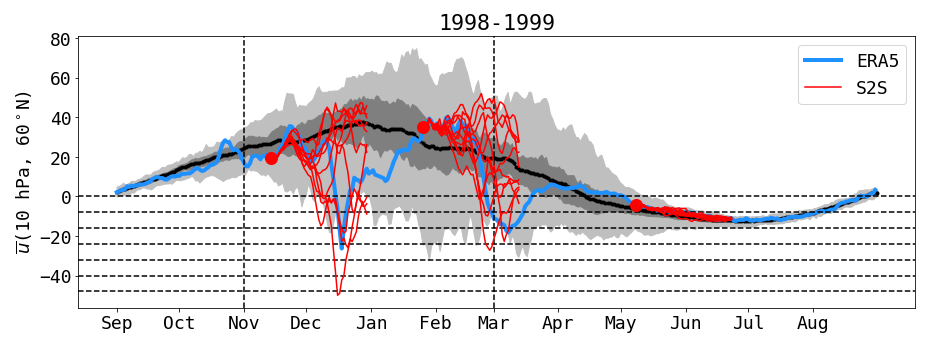

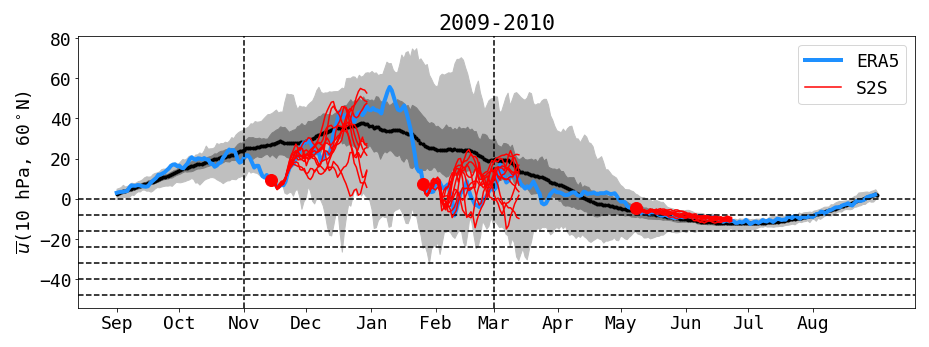

In [23]:
for year2plot in [1998,2009]:
    fig,ax = plt.subplots(figsize=(15,5))
    fig.set_facecolor("white")
    handles = []    
    
    obs_group = "ubar_observable"
    obs_name = "ubar_10_60"
    obs_label = "$\overline{u}$(10 hPa, 60$^\circ$N)"
    t_init_target_list = [75.0, 147.0, 250] # How many days into the season

    cond_e5 = 1*(feat_all["e5"]["time_observable"].sel(feature="year_szn_start") == year2plot)
    cond_s2 = 1*(feat_all["s2"]["time_observable"].isel(t_sim=0).sel(feature="year_szn_start") == year2plot)

    t_szn_1year = feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").isel(t_init=0,member=0).to_numpy()
    xticks, xticklabels = feat_strat.generate_seasonal_xticks(t_szn_1year)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_title(f"{year2plot}-{year2plot+1}")

    tpt_utils.plot_field_1d(
        feat_all["e5"][obs_group].sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(), 
        np.ones(feat_all["e5"][obs_group].t_sim.size), 
        feat_all["e5"]["time_observable"].sel(feature="t_szn").isel(t_init=0,member=0).to_numpy(),
        feat_name="", field_name=obs_label,
        fig=fig, ax=ax, nbins=365
    )

    h, = ax.plot(
        t_szn_1year,
        feat_all["e5"][obs_group].where(cond_e5,drop=True).sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(),
        color='dodgerblue', linewidth=4, label="ERA5"
    )
    handles += [h]
    ax.legend(handles=handles)
    fig.savefig(join(filedict["results"]["shared"], f"{year2plot}_illust_0"))

    # Draw thresholds
    u_thresh_list = np.arange(-52,1,4)
    for uth in u_thresh_list[np.arange(1,14,2)]: #[[-9,-7,-5,-3,-1]]:
        ax.axhline(y=uth, color='black', linestyle='--')
    ax.axvline(x=61, color='black', linestyle='--')
    ax.axvline(x=181, color='black', linestyle='--')
    fig.savefig(join(filedict["results"]["shared"], f"{year2plot}_illust_1"))


    t_szn_1year = feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").isel(t_init=0,member=0).to_numpy()
    for t_init_target in t_init_target_list:
        i_t_init = int(t_init_target / 3.5)
        for i_mem in range(feat_all["s2"]["time_observable"].member.size):
            x_ens, = (
                feat_all["s2"]["time_observable"].where(cond_s2,drop=True)
                .isel(t_init=i_t_init,member=i_mem)
                .sel(feature="t_szn").to_numpy()
            ),
            y_ens, = feat_all["s2"][obs_group].where(cond_s2,drop=True).isel(t_init=i_t_init,member=i_mem).sel(feature=obs_name).to_numpy(),
            h, = ax.plot(x_ens, y_ens, color='red', label="S2S")
            if i_mem == 0: 
                h = ax.scatter(x_ens[0], y_ens[0], color='red', marker='o', zorder=10, s=144)

    handles += [h]
    ax.legend(handles=handles)

    fig.savefig(join(filedict["results"]["shared"], f"{year2plot}_illust_2"))

# Assemble features for TPT.

Assemble and save the features with time delays. 

In [14]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [15]:
if assemble_tpt_features_flag:
    for src in ["s2","e5"]:
        feat_strat.assemble_tpt_features(feat_all[src], filedict["data"][src]["feat_tpt"]["dir"])

Reload them

In [16]:
feat_tpt = dict()
for src in ["s2","e5"]:
    feat_tpt[src] = xr.open_dataarray(join(filedict["data"][src]["feat_tpt"]["dir"], "features_tpt.nc"))

# Return time estimates

In the following, we sweep through a number of SSW definitions, varying both the threshold and the season. 

In [17]:
sep1 = 0
oct1,nov1,dec1,jan1 = np.cumsum([monthrange(1901,m)[1] for m in [9,10,11,12]])
feb1,mar1,apr1 = jan1 + np.cumsum([monthrange(1902,m)[1] for m in [1,2,3]])
u_thresh_list = np.arange(-52,1,4)
t_thresh_list = np.array([
    [oct1, apr1],
    [nov1, mar1],
    [oct1, mar1],
])[:2]
t_thresh_string_list = [
    "Oct-Mar", "Nov-Feb", 
]
np.save(join(filedict["results"]["shared"], "u_thresh_list"), u_thresh_list)
np.save(join(filedict["results"]["shared"], "t_thresh_list"), u_thresh_list)

## Method 1: count paths from each initialization

In [18]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [19]:
if path_counting_flag:
    for i_tth in range(len(t_thresh_list)):
        t_thresh = t_thresh_list[i_tth]
        rate_e5,rate_s2,prob_ssw_per_window = feat_strat.path_counting_rates(feat_all, feat_tpt, t_thresh, u_thresh_list, min_spread_time=0)
        rate_e5.to_netcdf(join(filedict["results"]["pathcounting"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
        rate_s2.to_netcdf(join(filedict["results"]["pathcounting"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))
        
        prob_ssw_per_window.to_netcdf(join(filedict["results"]["pathcounting"], 
                                   f"flux_per_window_{t_thresh[0]}-{t_thresh[1]}.nc"))

## Plot results

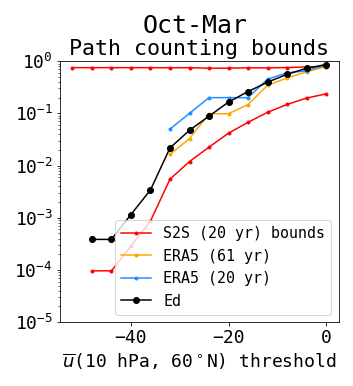

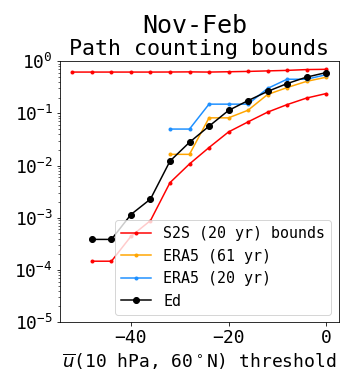

In [20]:
for i_tth in range(len(t_thresh_list)):
    t_thresh = t_thresh_list[i_tth]
    rate_e5 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
    rate_s2 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))

    fig,ax = plt.subplots(ncols=1, figsize=(5,5))
    fig.set_facecolor("white")
    ax.yaxis.set_tick_params(labelbottom=True)

    handles = []
    rate_s2 = rate_s2.where(rate_s2 > 0)
    #colors = ["red", "purple", "orange"]
    ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="lower",boot=0), color="red", marker='.')
    h, = ax.plot(
        rate_s2["u_thresh"], rate_s2.sel(bound="upper",boot=0), 
        color="red", marker='.', label=r"S2S (20 yr) bounds"
    )
    handles += [h]
    # Additionally plot ERA5 only
    h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1959-2019"), color="orange", marker='.', label="ERA5 (61 yr)")
    handles += [h]
    h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1996-2015"), color="dodgerblue", marker='.', label="ERA5 (20 yr)")
    handles += [h]

    # Additionally plot Ed's estimate
    h, = ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="ed",boot=0), color="black", marker="o", label="Ed")
    handles += [h]

    ax.set_yscale("log")
    ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold")
    ax.legend(handles=handles, fontsize="small")
    ax.set_title("Path counting bounds")
    ax.set_ylim([1e-5,1])

    fig.subplots_adjust(top=0.85)
    fig.suptitle(t_thresh_string_list[i_tth], y=0.98, fontsize=25)

# Method 2: DGA

In [21]:
reload(tpt_utils)
reload(feature_template)
reload(feature_stratosphere)
reload(tdmc_obj)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

Algorithmic parameters

In [22]:
max_delay_list = [1, 2, 5, 10, 15]
num_clusters_list = [50, 100, 150, 200]
clust_bndy_choice = "half"

In [23]:
for max_delay in max_delay_list[::-1]:
    print(f"----------- Time delay {max_delay} -------------")
    for num_clusters in num_clusters_list:
        print(f"-------- {num_clusters} clusters ------------")
        resultdir = join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}")
        os.makedirs(resultdir, exist_ok=True)
        
        if build_msm_flag:
            msm_feature_names = [f"ubar_10_60_delay{d}" for d in np.arange(max_delay)] 
            year_subset = np.arange(1996,2016)
            szn_stats_e5,msm_info = feat_strat.build_msm(
                max_delay, feat_all, feat_tpt, year_subset, msm_feature_names, resultdir, km_seed=43, num_clusters=num_clusters, 
            )

            szn_stats_e5.to_netcdf(join(resultdir, "szn_stats_e5.nc"))

        if dga_flag:
            szn_stats_e5 = xr.open_dataset(join(resultdir, "szn_stats_e5.nc"))
            msm_info = pickle.load(open(join(resultdir, "msm_info"), "rb"))
            feat_strat.dga_from_msm(
                msm_info, feat_tpt, szn_stats_e5, t_thresh_list, 
                u_thresh_list, resultdir, clust_bndy_choice)

        

----------- Time delay 15 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
-------- 200 clusters ------------
----------- Time delay 10 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
-------- 200 clusters ------------
----------- Time delay 5 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
-------- 200 clusters ------------
----------- Time delay 2 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
-------- 200 clusters ------------
----------- Time delay 1 -------------
-------- 50 clusters ------------
-------- 100 clusters ------------
-------- 150 clusters ------------
-------- 200 clusters ------------


In [24]:
def softlogit(q):
    eps = 1e-10
    qlogit = np.log(np.maximum(q, eps) / np.maximum(1-q, eps))
    qlogit = qlogit.where((q > eps)*(q > 1-eps))
    return qlogit
def softlog(q):
    eps = 1e-10
    qlog = np.log(np.maximum(q, eps))
    qlog = qlog.where(q > eps)
    return qlog

In [25]:
# Evaluate the specific choice of clustering by looking at the (normalized) log-likelihood
if tune_hyperparameters_flag:
    tau_max = 20
    for t_thresh in t_thresh_list:
        qp_lim_skill = xr.DataArray(
            coords={"u_thresh": u_thresh_list, "max_delay": max_delay_list, "num_clusters": num_clusters_list},
            dims=["u_thresh","max_delay","num_clusters"],
            data=np.nan
        )
        for u_thresh in u_thresh_list[::-1]: #[::-1]:
            print(f"-------------- U thresh {u_thresh}-------------------")
            feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], u_thresh)
            ab_tag_s2 = feat_strat.ab_test(feat_tpt["s2"])
            cej_s2 = feat_strat.cotton_eye_joe(feat_tpt["s2"], ab_tag_s2, "timesteps")
            qp_limited_s2 = 1.0*(cej_s2.sel(sense="until",state="B") <= tau_max).sel(
                t_sim=cej_s2["t_sim"].values[-1]-tau_max-3)
            comm_s2 = feat_strat.estimate_empirical_committor(cej_s2)
            for max_delay in max_delay_list[::-1]:
                #print(f"----------- Time delay {max_delay} -------------")
                for num_clusters in num_clusters_list:
                    #print(f"-------- {num_clusters} clusters ------------")
                    resultdir = join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}")
                    tau_pmf = pickle.load(open(join(
                        filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                        f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{u_thresh}"), "rb"))["tau_pmf"]
                    msm_info = pickle.load(open(join(
                        filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                        f"msm_info"), "rb"))
                    # Calculate an integrated error metric 
                    tau_leq46 = [np.nansum(tau_pmf[i][:tau_max], axis=0) for i in range(len(tau_pmf))]
                    qp_limited_dga = feat_strat.broadcast_field_msm2dataarray(
                        msm_info["s2"], tau_leq46).sel(t_sim=cej_s2["t_sim"].values[-1]-tau_max-3)
                    print(f"dga tpmf: fracfinite = {np.mean(np.isfinite(qp_limited_dga.values))}")
                    print(f"min and max: {np.nanmin(qp_limited_dga.values)}, {np.nanmax(qp_limited_dga.values)}")

                    # Compute normalized log likelihood
                    clim_prob = qp_limited_s2.to_numpy().mean()
                    if (clim_prob > 0) and (clim_prob < 1):
                        ll_centered = (
                            (qp_limited_s2*softlog(qp_limited_dga/clim_prob)).sum()
                            + ((1-qp_limited_s2)*softlog((1-qp_limited_dga)/(1-clim_prob))).sum()
                        )
                        ll_centered_optimal = (
                            (qp_limited_s2*softlog(qp_limited_s2/clim_prob)).sum()
                            + ((1-qp_limited_s2)*softlog((1-qp_limited_s2)/(1-clim_prob))).sum()
                        )
                        qp_lim_skill.loc[dict(u_thresh=u_thresh,max_delay=max_delay,num_clusters=num_clusters)] = (
                            ll_centered / ll_centered_optimal
                        )    
                        print(f"clim_prob = {clim_prob}; ll_centered = {ll_centered.values}; ll_centered_optimal = {ll_centered_optimal.values}")
        qp_lim_skill.to_netcdf(join(filedict["results"]["dga"], f"qp_lim_skill_{t_thresh[0]}-{t_thresh[1]}.nc"))
        del qp_lim_skill

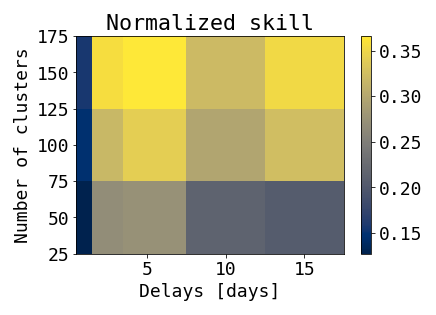

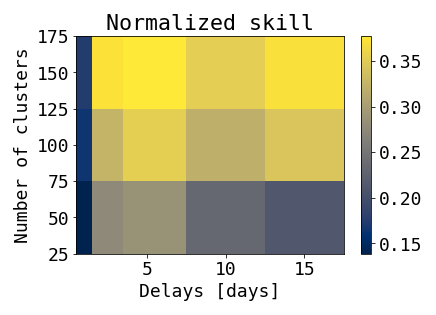

In [26]:
for t_thresh in t_thresh_list:
    qp_lim_skill = xr.open_dataarray(
        join(filedict["results"]["dga"], f"qp_lim_skill_{t_thresh[0]}-{t_thresh[1]}.nc"))
    fig,ax = plt.subplots()
    fig.set_facecolor("white")
    xr.plot.pcolormesh(
        qp_lim_skill.isel(num_clusters=slice(None,-1))
        .mean(dim="u_thresh"),
        x="max_delay",y="num_clusters",cmap="cividis")
    ax.set_xlabel("Delays [days]")
    ax.set_ylabel("Number of clusters")
    ax.set_title("Normalized skill")
    fig.savefig(join(filedict["results"]["dga"], f"qplim_skill_plot_{t_thresh[0]}-{t_thresh[1]}"))

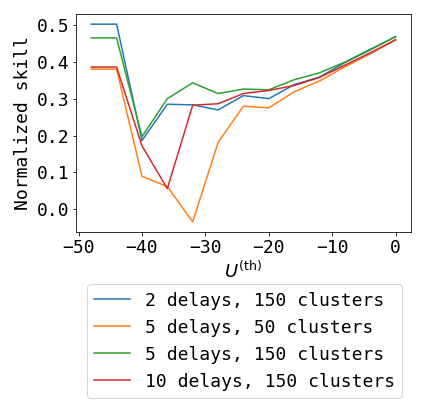

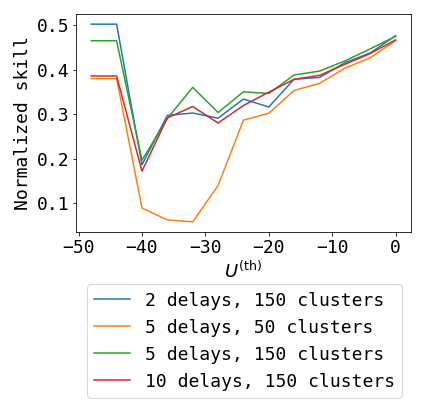

In [27]:
# Plot the loss as a function of zonal wind threshold
for t_thresh in t_thresh_list:
    qp_lim_skill = xr.open_dataarray(join(filedict["results"]["dga"], f"qp_lim_skill_{t_thresh[0]}-{t_thresh[1]}.nc"))
    fig,ax = plt.subplots()
    fig.set_facecolor("white")
    pairs2plot = [[2,150],[5,50],[5,150],[10,150]]
    handles = []
    for p in pairs2plot:
        h, = xr.plot.plot(
            qp_lim_skill.sel(max_delay=p[0],num_clusters=p[1]), 
            x="u_thresh", label=f"{p[0]} delays, {p[1]} clusters")
        handles += [h]
    ax.legend(handles=handles, bbox_to_anchor=(1.0,-0.2))
    ax.set_title("")
    ax.set_xlabel("$U^{\mathrm{(th)}}$")
    ax.set_ylabel("Normalized skill")
    fig.savefig(join(filedict["results"]["dga"], f"qplim_skill_vs_uth_{t_thresh[0]}-{t_thresh[1]}"))
    #plt.close(fig)

Apparently, an delay of 5 and a cluster number of 150 is all-around optimal.

In [28]:
max_delay_opt = 5
num_clusters_opt = 150

# Compute error bars for the chosen MSM by repeating the analysis with many randomly chosen subsets.

In [29]:

rng = default_rng(seed=123)
num_boot = 20
all_years = np.arange(1996,2016)
year_subsets = np.array([
    rng.choice(all_years, size=len(all_years)//2, replace=False)
    for i_boot in range(num_boot)
])
year_szn_start = feat_all["s2"]["time_observable"].isel(t_sim=0,member=0).sel(feature="year_szn_start").to_numpy()


In [30]:
if bootstrap_flag:
    for num_clusters in [num_clusters_opt]:
        for max_delay in [max_delay_opt]:
            for i_boot in range(num_boot):
                print(f"\n\n------------- Beginning bootstrap {i_boot} out of {num_boot} "
                      f"for {num_clusters} clusters and {max_delay} delays-----------\n\n")
                
                resultdir = join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", f"boot{i_boot}")
                os.makedirs(resultdir, exist_ok=True)

                msm_feature_names = [f"ubar_10_60_delay{d}" for d in np.arange(max_delay)] 
                szn_stats_e5,msm_info = feat_strat.build_msm(
                    max_delay, feat_all, feat_tpt, year_subsets[i_boot], msm_feature_names, resultdir, km_seed=43, num_clusters=num_clusters, 
                )

                szn_stats_e5.to_netcdf(join(resultdir, "szn_stats_e5.nc"))

                szn_stats_e5 = xr.open_dataset(join(resultdir, "szn_stats_e5.nc"))
                msm_info = pickle.load(open(join(resultdir, "msm_info"), "rb"))
                feat_strat.dga_from_msm(
                    msm_info, feat_tpt, szn_stats_e5, t_thresh_list, 
                    u_thresh_list, resultdir, clust_bndy_choice)


# Plot all the results together, regarding rates

In [31]:
!ls {filedict["results"]["dga"]}

cl100_md1   cl150_md2	cl50_md10		qplim_skill_plot_30-212.png
cl100_md10  cl150_md5	cl50_md15		qplim_skill_plot_61-181.png
cl100_md15  cl200_md1	cl50_md2		qplim_skill_vs_uth_30-212.png
cl100_md2   cl200_md10	cl50_md5		qplim_skill_vs_uth_61-181.png
cl100_md5   cl200_md15	dectree.nc		szn_dist.png
cl150_md1   cl200_md2	lassreg.nc
cl150_md10  cl200_md5	qp_lim_skill_30-212.nc
cl150_md15  cl50_md1	qp_lim_skill_61-181.nc


In [32]:
def binomial_error_bar(phat, n, conf_int):
    # Give the confidence intervals for p if the estimate is phat 
    lower = binom.isf(0.5*(1 + conf_int), n, phat) / n
    upper = binom.isf(0.5*(1 - conf_int), n, phat) / n
    return lower,upper

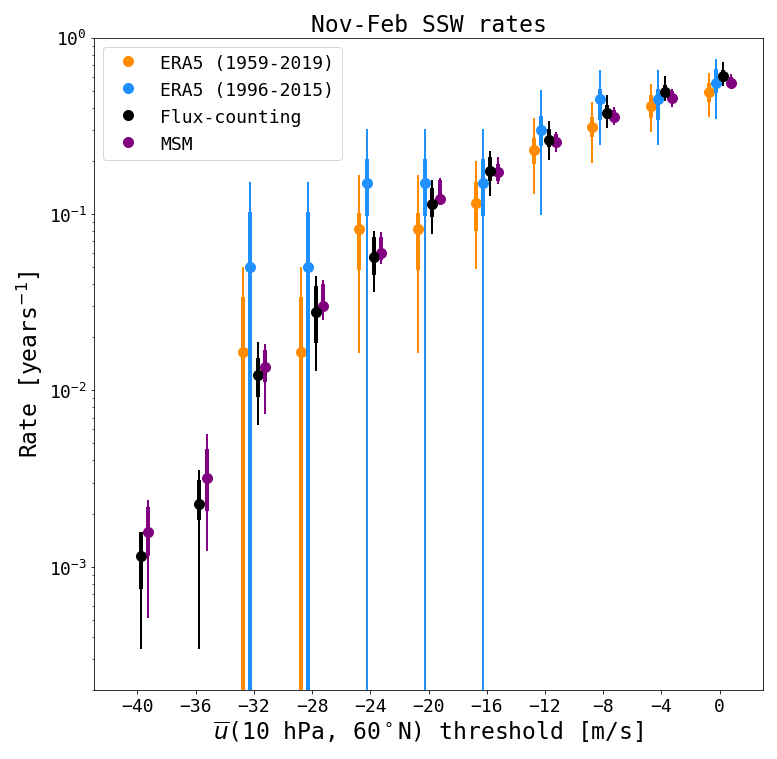

In [44]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]
i_uth_min = 3
conf_int_range_list = [0.95, 0.5]
errbar_lw_list = [2,4]
markersize = 10

errbar_gap = 0.5
#errbar_lw = 4



rate_e5 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = xr.open_dataarray(join(filedict["results"]["pathcounting"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = rate_s2.where(rate_s2 > 0)


fig,ax = plt.subplots(figsize=(12,12))
fig.set_facecolor("white")
handles = []

def format_axis(myax):
    ax.set_yscale("log")
    ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold [m/s]", fontsize=23)
    ax.set_ylabel("Rate [years$^{-1}$]", fontsize=23)
    ax.set_title(f"{t_thresh_string_list[i_tth]} SSW rates", fontsize=23)
    ax.set_ylim([2e-4,1])
    ax.set_xlim([u_thresh_list[i_uth_min]-3, u_thresh_list.max()+3])
    ax.set_xticks(u_thresh_list[i_uth_min:])
    return

# --------------- Method 0: direct counting from ERA5 --------------
# Long ERA5
# Point estimate
h, = ax.plot(
    rate_e5["u_thresh"]-1.5*errbar_gap, rate_e5.where(rate_e5>0).sel(falls="1959-2019"), 
    color="darkorange", marker='o', markersize=markersize, linewidth=0, label="ERA5 (1959-2019)"
)
handles = [h] + handles
# Error bars 
for i_ci in range(len(conf_int_range_list)):
    lower,upper = binomial_error_bar(
        rate_e5.sel(falls="1959-2019").to_numpy()[i_uth_min:],
        61*np.ones(len(u_thresh_list[i_uth_min:])),
        conf_int_range_list[i_ci])
    for j in range(len(lower)):
        ax.plot(np.ones(2)*(u_thresh_list[i_uth_min+j]-1.5*errbar_gap), [lower[j],upper[j]], 
                color="darkorange",linewidth=errbar_lw_list[i_ci])

# Short ERA5
# Point estimate    
h, = ax.plot(
    rate_e5["u_thresh"]-0.5*errbar_gap, rate_e5.where(rate_e5>0).sel(falls="1996-2015"), 
    color="dodgerblue", marker='o', markersize=markersize, linewidth=0, label="ERA5 (1996-2015)"
)
handles = [h] + handles
# Error bars 
for i_ci in range(len(conf_int_range_list)):
    lower,upper = binomial_error_bar(
        rate_e5.sel(falls="1996-2015").to_numpy()[i_uth_min:],
        20*np.ones(len(u_thresh_list[i_uth_min:])), conf_int_range_list[i_ci])
    for j in range(len(lower)):
        ax.plot(np.ones(2)*(u_thresh_list[i_uth_min+j]-0.5*errbar_gap), [lower[j],upper[j]], 
                color="dodgerblue",linewidth=errbar_lw_list[i_ci])
    #ax.fill_between(u_thresh_list[i_uth_min:], lower, upper, color="dodgerblue", alpha=0.25, zorder=-1)

ax.legend(handles=handles[::-1], fontsize="medium", loc="upper left")
fig.savefig(join(filedict["results"]["shared"], f"rates_itth{i_tth}_0"), bbox_inches="tight")

# --------------- Method 2: flux-counting estimate from S2S --------------
point_est = rate_s2.sel(bound="ed",boot=0).isel(u_thresh=slice(i_uth_min,None))
h, = ax.plot(point_est["u_thresh"]+0.5*errbar_gap, point_est.to_numpy(), color="black", marker="o", 
             markersize=markersize, linewidth=0, label="Flux-counting")
#h, = xr.plot.plot(point_est, x="u_thresh", color="black", marker="o", label="Flux-counting")
for i_ci in range(len(conf_int_range_list)):
    boot_quantiles = rate_s2.isel(u_thresh=slice(i_uth_min,None),boot=slice(1,None)).sel(bound="ed").quantile(
        [0.5*(1-conf_int_range_list[i_ci]), 0.5*(1+conf_int_range_list[i_ci])], dim="boot")
    rate_lower = 2*point_est - boot_quantiles.isel(quantile=1)
    rate_upper = 2*point_est - boot_quantiles.isel(quantile=0)
    for j in range(point_est["u_thresh"].size):
        ax.plot(np.ones(2)*(u_thresh_list[i_uth_min+j]+0.5*errbar_gap), 
                [rate_lower.isel(u_thresh=j).item(), rate_upper.isel(u_thresh=j).item()],
                color="black",zorder=2,linewidth=errbar_lw_list[i_ci])

#xr.plot.plot(2*point_est - boot_quantiles.isel(quantile=1), x="u_thresh", color="black", ax=ax)
#xr.plot.plot(2*point_est - boot_quantiles.isel(quantile=0), x="u_thresh", color="black", ax=ax)

handles = [h] + handles
ax.legend(handles=handles[::-1], fontsize="medium", loc="upper left")
format_axis(ax)
fig.savefig(join(filedict["results"]["shared"], f"rates_itth{i_tth}_2"), bbox_inches="tight")


# ---------------------- Method 3: DGA (one result at a time) -----------------------------

for max_delay in [max_delay_opt]:
    for num_clusters in [num_clusters_opt]:    
        # Using all data
        dga_rates = pickle.load(
            open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                      f"dga_rates_{t_thresh[0]}-{t_thresh[1]}"), "rb")
        )["s2"][i_uth_min:]
        dga_rates[dga_rates==0] = np.nan
        h, = ax.plot(u_thresh_list[i_uth_min:]+1.5*errbar_gap, 
                     dga_rates, color='purple', linestyle='--', 
                     linewidth=0, label="MSM", zorder=-1, alpha=1,
                     marker='o', markersize=markersize)
        handles = [h] + handles
        ax.legend(handles=handles[::-1], fontsize="medium", loc="upper left")
        format_axis(ax)
        fig.savefig(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", f"rates_itth{i_tth}"), bbox_inches="tight")
        dga_rates_boot = []
        # Bootstrap confidence intervals
        for i_boot in range(num_boot):
            dga_rates_iboot  = pickle.load(
                open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                          f"boot{i_boot}", f"dga_rates_{t_thresh[0]}-{t_thresh[1]}"), "rb")
            )["s2"][i_uth_min:]
            dga_rates_iboot[dga_rates_iboot==0] = np.nan
            dga_rates_boot += [dga_rates_iboot]
        dga_rates_boot = np.array(dga_rates_boot)

        for i_ci in range(len(conf_int_range_list)):
            boot_quantiles = np.nanquantile(
                dga_rates_boot, [0.5*(1-conf_int_range_list[i_ci]), 0.5*(1+conf_int_range_list[i_ci])], axis=0)
            rate_lower = 2*dga_rates - boot_quantiles[1]
            rate_upper = 2*dga_rates - boot_quantiles[0]
            #ax.fill_between(u_thresh_list[i_uth_min:], rate_lower, rate_upper, color="purple", alpha=0.25, zorder=-2)
            for j in range(len(rate_lower)):
                ax.plot(np.ones(2)*(u_thresh_list[i_uth_min+j]+1.5*errbar_gap), [rate_lower[j], rate_upper[j]], 
                        color="purple",zorder=2,linewidth=errbar_lw_list[i_ci])

        format_axis(ax)
        fig.savefig(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", f"rates_itth{i_tth}_errbars"), bbox_inches="tight")
        
    
format_axis(ax)
fig.savefig(join(filedict["results"]["shared"], f"results_itth{i_tth}_4"), bbox_inches="tight")


In [40]:
filedict["results"]["shared"]

'/scratch/jf4241/ecmwf_data/results/tpt_quantities/2022-11-22/shared'

TODO: plot some integrated error metric and plot it against the cluster number and delay.

# Find the important features

### Do a sparse linear regression over features. 

In [41]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]
num_clusters = num_clusters_opt
max_delay = max_delay_opt

delays = np.arange(max_delay)
szn_stats_e5 = xr.open_dataset(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "szn_stats_e5.nc"))
msm_info = pickle.load(open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "msm_info"), "rb"))

t_bounds = [t_thresh[0], t_thresh[0]+30]

feats2regress = [f"ubar_{lev}_60_delay{d}" for lev in [10,100,500,850] for d in delays]
feats2regress_labels = [r"$\overline{u}$(%i hPa, 60$^\circ$N, t-%i)"%(lev,d) for lev in [10,100,500,850] for d in delays]
feats2regress += [f"vT_{lev}_{wn}_runavg10" for lev in [10,100,500,850] for wn in [0,1,2]]
feats2regress_labels += [r"$\overline{vT}$(%i hPa, 60$^\circ$N, wave-%i, 10-day mean)"%(lev,wn) for lev in [10,100,500,850] for wn in [0,1,2]]
stackmap = dict({"sample": ["t_init","member","t_sim"]})
X = (
    feat_tpt["s2"].sel(feature=feats2regress)
    .isel(t_init=msm_info["s2"]["idx_t_init"])
    .stack(stackmap).transpose("sample","feature")
)

In [42]:
# Store regression results in a dataarray
if regress_over_features_flag:
    reg_coef = xr.DataArray(
        coords={"u_thresh": u_thresh_list, "feature": feats2regress, "target": ["committor","leadtime"]}, 
        dims=["u_thresh","feature","target"], data=np.nan)
    reg_bias = xr.DataArray(
        coords={"u_thresh": u_thresh_list, "target": ["committor","leadtime"]},
        dims=["u_thresh","target"], data=np.nan)
    reg_rsq = xr.DataArray(
        coords={"u_thresh": u_thresh_list, "target": ["committor","leadtime"]}, 
        dims=["u_thresh","target"], data=np.nan)

    dec_imp = xr.DataArray(
        coords={"u_thresh": u_thresh_list, "feature": feats2regress, "target": ["committor","leadtime"]}, 
        dims=["u_thresh","feature","target"], data=np.nan)
    dec_rsq = xr.DataArray(
        coords={"u_thresh": u_thresh_list, "target": ["committor","leadtime"]}, 
        dims=["u_thresh","target"], data=np.nan)

    for i_uth in range(1,len(u_thresh_list)):
        u_thresh = u_thresh_list[i_uth]
        print(f"Beginning regression in threshold {u_thresh}")
        feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], u_thresh)
        dga_results = pickle.load(open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{u_thresh}"), "rb"))
        qp = dict({
            "s2": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qp"]), #"e5": comm_e5.sel(sense="until"),
        })
        eta = dict({
            "s2": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["leadtime"]["mean"]), #"e5": comm_e5.sel(sense="until"),
        })
        Y_qp = qp["s2"].stack(stackmap)
        Y_eta = eta["s2"].stack(stackmap)
        t_szn = feat_tpt["s2"].sel(feature="t_szn").isel(t_init=msm_info["s2"]["idx_t_init"]).stack(stackmap)

        idx2fit_candidates = np.where(
            (t_szn >= t_bounds[0]) * (t_szn < t_bounds[1])
            * np.all(np.isfinite(X.values), axis=1) * np.isfinite(Y_qp.values)
            * (Y_qp > 1e-6) * (1-Y_qp > 1e-6)
        )[0]
        if len(idx2fit_candidates) > 0:
            idx2fit = np.random.choice(idx2fit_candidates, size=min(1000,len(idx2fit_candidates)), replace=True)
            Y_transformed = dict({
                "committor":  np.log(Y_qp.values[idx2fit] / (1 - Y_qp.values[idx2fit])),
                "leadtime": np.log(Y_eta.values[idx2fit])
            })
            for target in ["committor","leadtime"]:
                # ----------- Lasso regression -----------
                reg = Lasso(alpha=0.1).fit(X.values[idx2fit], Y_transformed[target])
                reg_bias.loc[dict(u_thresh=u_thresh,target=target)] = reg.intercept_
                reg_coef.loc[dict(u_thresh=u_thresh,target=target)] = reg.coef_
                reg_rsq.loc[dict(u_thresh=u_thresh,target=target)] = reg.score(X.values[idx2fit], Y_transformed[target])
                # ------- Decision tree regression --------
                #dec = tree.DecisionTreeRegressor(
                dec = RandomForestRegressor(n_estimators=10,
                    max_depth=3).fit(X.values[idx2fit], Y_transformed[target])
                dec_imp.loc[dict(u_thresh=u_thresh,target=target)] = dec.feature_importances_
                dec_rsq.loc[dict(u_thresh=u_thresh,target=target)] = dec.score(X.values[idx2fit], Y_transformed[target])

    dectree = xr.Dataset(data_vars={"importance": dec_imp, "rsq": dec_rsq})
    dectree.to_netcdf(join(filedict["results"]["dga"], "dectree.nc"))
    lassreg = xr.Dataset(data_vars={"bias": reg_bias, "coef": reg_coef, "rsq": reg_rsq})
    lassreg.to_netcdf(join(filedict["results"]["dga"], "lassreg.nc"))

In [43]:
dectree = xr.open_dataset(join(filedict["results"]["dga"], "dectree.nc")).isel(u_thresh=slice(1,None))
lassreg = xr.open_dataset(join(filedict["results"]["dga"], "lassreg.nc")).isel(u_thresh=slice(1,None))

In [44]:
lassreg.data_vars.keys()

KeysView(Data variables:
    bias     (u_thresh, target) float64 ...
    coef     (u_thresh, feature, target) float64 ...
    rsq      (u_thresh, target) float64 ...)

## Plot regression coefficients 

In [45]:
# Select only the important features to plot
idx_feats2plot = np.where(["ubar_10_" in ftp or "vT" in ftp for ftp in feats2regress])[0]
feats2plot = [feats2regress[i] for i in idx_feats2plot]
feats2plot_labels = [feats2regress_labels[i] for i in idx_feats2plot]

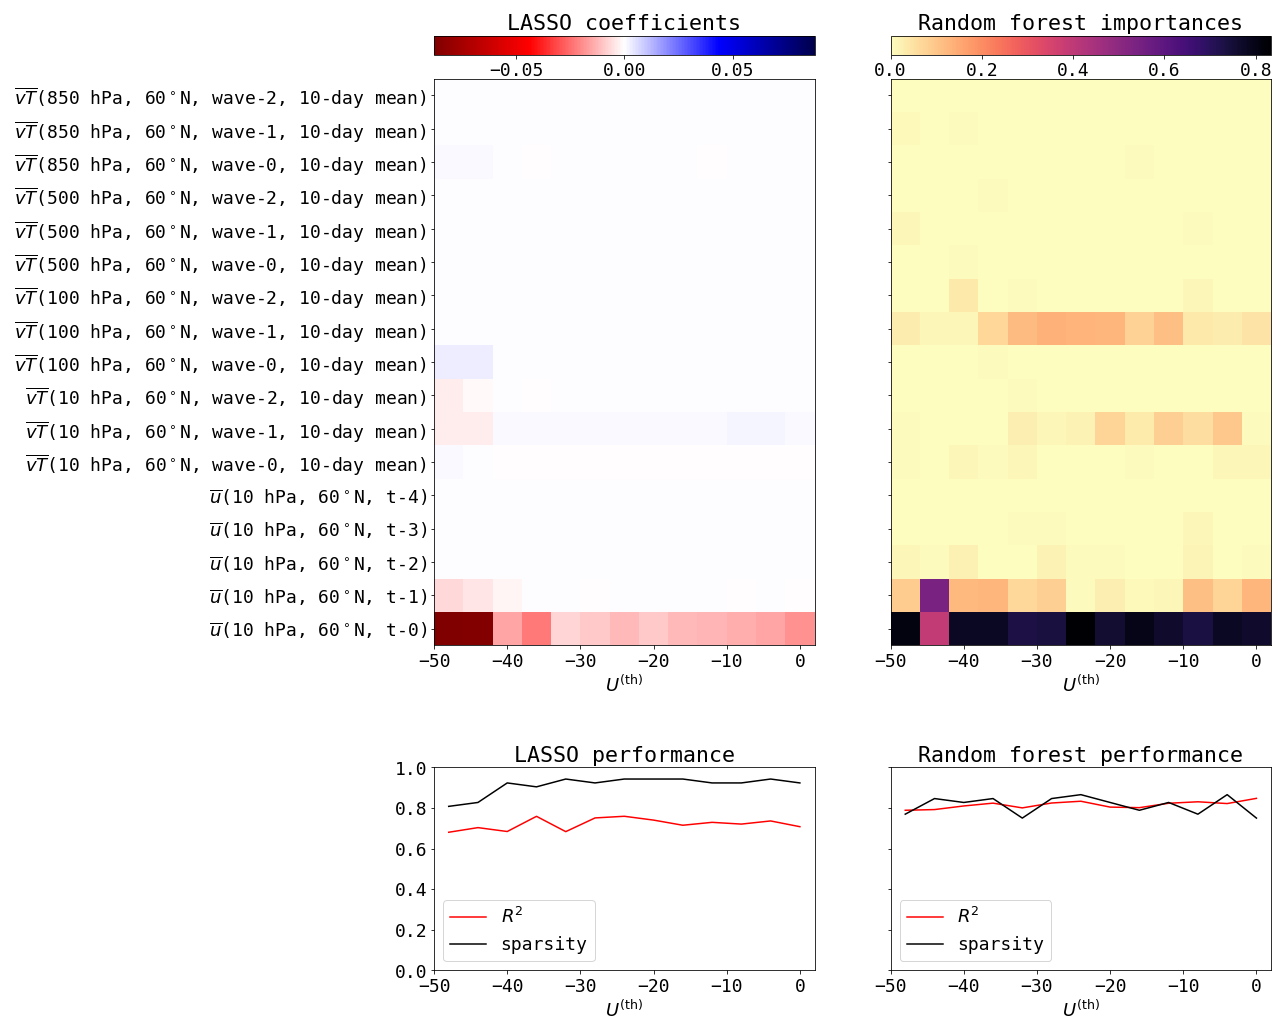

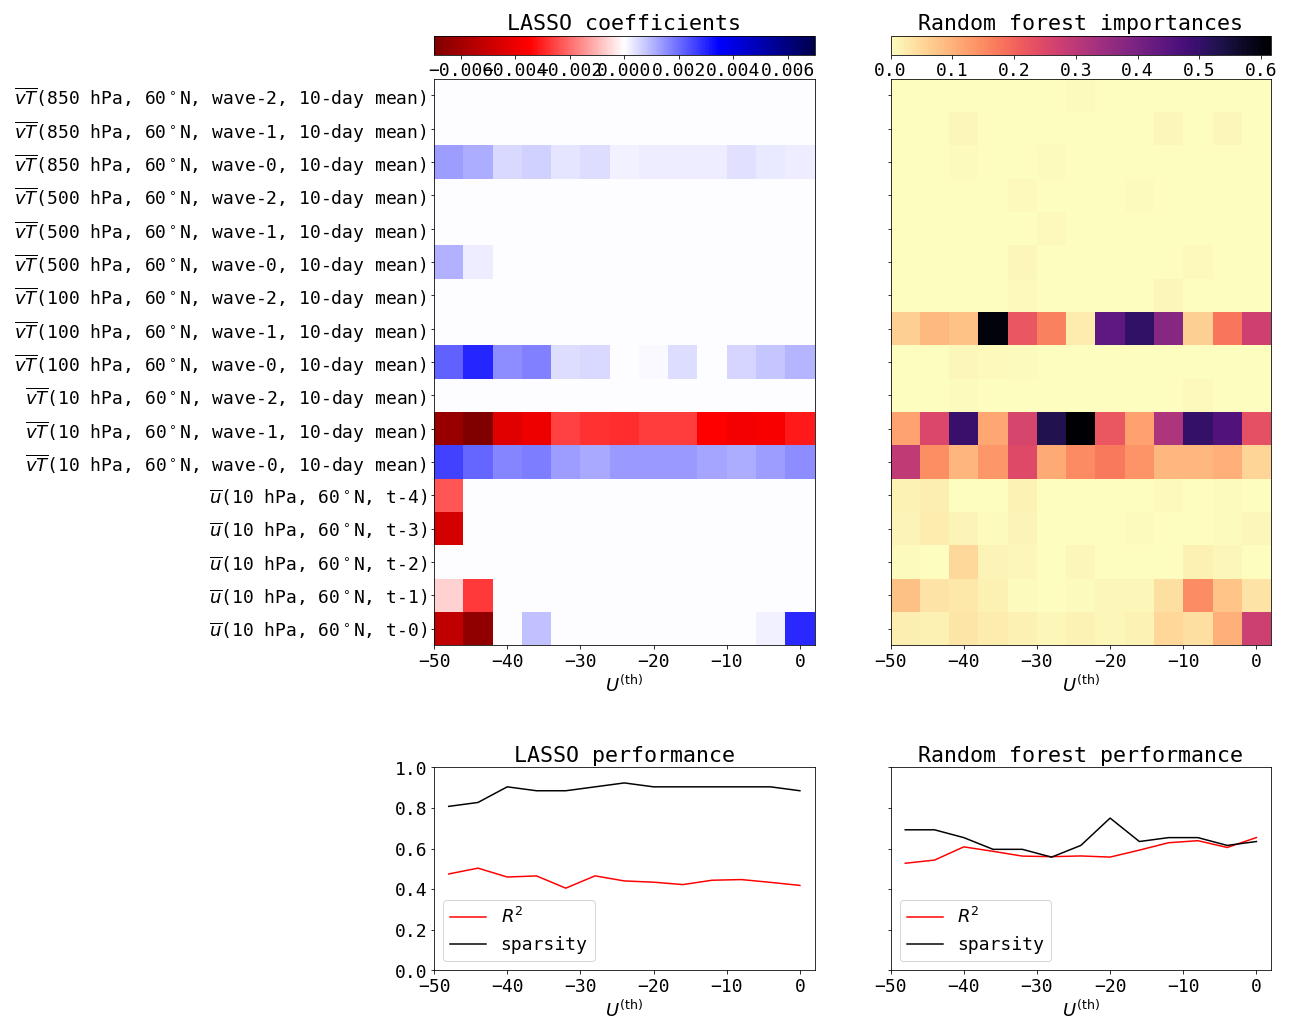

In [46]:
target_labels = dict({"committor": "Committor", "leadtime": "Lead time"})
for target in ["committor","leadtime"]:
    fig,axes = plt.subplots(
        ncols=2, nrows=2, figsize=(15,15), sharex=True, sharey='row', 
        gridspec_kw={"width_ratios": [1,1], "height_ratios": [3,1], "hspace": 0.3})
    fig.set_facecolor("white")
    #fig.suptitle(f"{target_labels[target]} regression")
    fig.subplots_adjust(top=0.99,hspace=0.15)
    
    divider0 = make_axes_locatable(axes[0,0])
    cax0 = divider0.append_axes("top", size="7%", pad="0.5%")
    divider1 = make_axes_locatable(axes[0,1])
    cax1 = divider1.append_axes("top", size="7%", pad="0.5%")
    
    cax1.set_title("Random forest importances")
    cax0.set_title("LASSO coefficients")
    cax1.axis("off")
    cax0.axis("off")
    
    ax = axes[0,1]
    
    xr.plot.pcolormesh(
        dectree["importance"].sel(target=target).sel(feature=feats2plot)
        .assign_coords({"feature": np.arange(len(feats2plot))}), 
        x="u_thresh", y="feature", cmap=plt.cm.magma_r, ax=ax, #cbar_ax=axes[0,0],
        cbar_kwargs={"orientation": "horizontal", "pad": 0.0, 
                     "ax": cax1, "fraction": 1.0, "label": ""})        
    ax.set_ylabel("")
    ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
    ax.set_ylabel("")
    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.set_title("")
    
    ax = axes[0,0]
    xr.plot.pcolormesh(
        lassreg["coef"].sel(target=target)
        .sel(feature=feats2plot)
        .assign_coords({"feature": np.arange(len(feats2plot))}), 
        x="u_thresh", y="feature", cmap=plt.cm.seismic_r, ax=ax, #cbar_ax=axes[0,1],
        cbar_kwargs={"orientation": "horizontal", "pad": 0.0, 
                     "ax": cax0, "fraction": 1.0, "label": ""})
    ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
    
    ax.set_yticks(np.arange(len(feats2plot)))
    ax.set_yticklabels(feats2plot_labels)
    ax.set_ylabel("")
    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.set_title("")
    
    ax = axes[1,1]
    h_rsq, = xr.plot.plot(
        dectree["rsq"].sel(target=target), x="u_thresh",
        ax=ax, color="red", label="$R^2$")
    h_sps, = xr.plot.plot(
        (dectree["importance"]==0).sel(target=target).mean(dim="feature"), x="u_thresh",
        ax=ax, color="black", label="sparsity")
    ax.legend(handles=[h_rsq,h_sps])
    ax.set_ylabel(r"")
    ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
    ax.set_ylim([0,1])
    ax.set_title("Random forest performance")
    
    ax = axes[1,0]
    h_rsq, = xr.plot.plot(
        lassreg["rsq"].sel(target=target), x="u_thresh",
        ax=ax, color="red", label="$R^2$")
    h_sps, = xr.plot.plot(
        (lassreg["coef"]==0).sel(target=target).mean(dim="feature"), x="u_thresh",
        ax=ax, color="black", label="sparsity")
    ax.legend(handles=[h_rsq,h_sps])
    ax.set_ylabel("")
    ax.set_xlabel(r"$U^{\mathrm{(th)}}$")
    ax.set_ylim([0,1])
    ax.set_title("LASSO performance")
    
    fig.savefig(join(filedict["results"]["shared"], f"coefs_uthall_{target}"))

## Plot some pictures of the committor and lead time.

In [47]:
reload(tpt_utils)
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

lead time PMF

In [48]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]
t_thresh_str = ([
    (
        datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
    ).strftime("%b %d")
    for i in range(2)]
)

In [49]:
qplimited_labels = dict({"s2": "S2S", "dga": "MSM"})
if plot_2d_images:
    tau_max = 20
    for i_uth in [9,11,13]: #np.arange(1,len(u_thresh_list),4):
        u_thresh = u_thresh_list[i_uth]
        szn_stats_e5 = xr.open_dataset(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "szn_stats_e5.nc"))
        msm_info = pickle.load(open(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", "msm_info"), "rb"))


        dga_results = pickle.load(open(
            join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
                 f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{u_thresh}"), "rb"))
        feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], u_thresh)
        ab_tag_e5 = feat_strat.ab_test(feat_tpt["e5"])
        cej_e5 = feat_strat.cotton_eye_joe(feat_tpt["e5"], ab_tag_e5, "timechunks")
        comm_e5 = feat_strat.estimate_empirical_committor(cej_e5)
        ab_tag_s2 = feat_strat.ab_test(feat_tpt["s2"])
        cej_s2 = feat_strat.cotton_eye_joe(feat_tpt["s2"], ab_tag_s2, "timesteps")
        comm_s2 = feat_strat.estimate_empirical_committor(cej_s2)


        qp = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qp"]), 
            "e5": comm_e5.sel(sense="until"),
            "s2": comm_s2.sel(sense="until"),
        })
        qm = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qm"]), 
            "e5": comm_e5.sel(sense="since"),
            "s2": comm_s2.sel(sense="since"),
        })
        pi = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["pi"], density_flag=True), 
            "e5": xr.ones_like(qm["e5"]),
            "s2": xr.ones_like(qm["s2"]),
        })
        eta = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["leadtime"]["mean"]), 
        })
        prob_ssw_46 = [np.nansum(tau_pmf[:tau_max+1], axis=0) for tau_pmf in dga_results["tau_pmf"]]
        qp_limited = dict({
            "dga": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], prob_ssw_46), 
            "e5": 1.0*(cej_e5.sel(sense="until",state="B") <= tau_max),
            "s2": 1.0*(cej_s2.sel(sense="until",state="B") <= tau_max),
        })

        qp_vmin = min(qp["dga"].where(qp["dga"] > 0).min(), qp["s2"].where(qp["s2"] > 0).min())
        qp_limited_vmin = min(qp_limited["dga"].where(qp_limited["dga"] > 0).min(), qp_limited["s2"].where(qp_limited["s2"] > 0).min())
        qp_limited_vmax = max(qp_limited["dga"].max(), qp_limited["s2"].max())

        for combo in np.arange(10)[::-1]:
            if combo == 0:
                feat_names = ["vT_10_0_runavg10","vT_10_1_runavg10"]
            elif combo == 1:
                feat_names = ["vT_100_0_runavg10","vT_100_1_runavg10"]
            elif combo == 2:
                feat_names = ["ubar_10_60_delay0","ubar_10_60_delay4"]
            elif combo == 3:
                feat_names = ["ubar_10_60_delay0","vT_10_1_runavg10"]
            elif combo == 4:
                feat_names = ["ubar_10_60_delay0","vT_100_1_runavg10"]
            # Now the individual components plotted against time 
            elif combo == 5:
                feat_names = ["t_szn","ubar_10_60_delay0"]
            elif combo == 6:
                feat_names = ["t_szn","vT_10_0_runavg10"]
            elif combo == 7:
                feat_names = ["t_szn","vT_10_1_runavg10"]
            elif combo == 8:
                feat_names = ["t_szn","vT_100_0_runavg10"]
            elif combo == 9:
                feat_names = ["t_szn","vT_100_1_runavg10"]
                
            # Random ones
            elif combo == 16:
                feat_names = ["ubar_100_60_delay0","ubar_500_60_delay0"]
                feat_labels = [r"$\overline{u}(100\,\mathrm{hPa},60^\circ\mathrm{N},t)$", r"$\overline{u}(500\,\mathrm{hPa},60^\circ\mathrm{N},t)$"]
                             
            feat_labels = ["",""]
            if feat_names[0] == "t_szn":
                feat_labels[0] = ""
                feat_labels[1] = feats2regress_labels[feats2regress.index(feat_names[1])] 
                t_bounds = [t_thresh[0], t_thresh[1]]
            else:
                feat_labels = [feats2regress_labels[feats2regress.index(fn)] for fn in feat_names]
                t_bounds = [t_thresh[0], t_thresh[0] + 30]
            # --------- Prepare features common to all plots -----------
            date_bounds_str = ([
                (
                    datetime.date(1901, feat_strat.szn_start['month'], feat_strat.szn_start['day'])
                    + datetime.timedelta(days=int(t_bounds[i]))
                ).strftime("%b %d")
                for i in range(2)]
            )
            cond = (
                (feat_tpt["s2"].sel(feature="t_szn") > t_bounds[0]) 
                * (feat_tpt["s2"].sel(feature="t_szn") < t_bounds[1])
            )
            stackmap = {"sample": ("t_init","member","t_sim")}
            features = np.array([
                feat_tpt["s2"].where(cond).sel(feature=feat_names[0])
                .isel(t_init=msm_info["s2"]["idx_t_init"])
                .stack(stackmap).to_numpy().flatten(),
                feat_tpt["s2"].where(cond).sel(feature=feat_names[1])
                .isel(t_init=msm_info["s2"]["idx_t_init"])
                .stack(stackmap).to_numpy().flatten()
            ]).T
            # ------------------- Expected lead time ----------------------
            src = "dga"
            weight = pi[src].stack(stackmap).to_numpy().flatten()
            fig,ax = plt.subplots(figsize=(8,8))
            fig.set_facecolor('white')
            field = eta[src].stack(stackmap).to_numpy().flatten()
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                stat_name="mean", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm_r, logscale=False, 
                pcolor_flag=False, contour_flag=True, cbar_flag=True
            )
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                stat_name="weightsum", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm_r, logscale=True, 
                pcolor_flag=False, contour_empty_flag=True, cbar_flag=False, num_levels=5
            )            
            ax.set_title(r"Expected lead time $\eta^+$; $U^{\mathrm{(th)}}=%i$"%(u_thresh))
            ax.set_xlabel(feat_labels[0])
            ax.set_ylabel(feat_labels[1])
            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)
            if feat_names[0] == "t_szn":
                xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                print(f"xticks = {xticks}, xticklabels = {xticklabels}")
                ax.set_xlabel("")
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticklabels)
            fig.savefig(
                join(filedict["results"]["shared"], f"combo{combo}_uth{u_thresh}_{date_bounds_str[0]}-{date_bounds_str[1]}_eta"
                     .replace(" ","").replace(".","p")))
            plt.close(fig)
            # ------------------- Lead time <= tau_max ----------------------
            for src in ["dga","s2"]:
                isel = None if src == "dga" else dict(t_init=msm_info["s2"]["idx_t_init"])
                weight = pi[src].isel(isel).stack(stackmap).to_numpy().flatten()                
                fig,ax = plt.subplots(figsize=(8,8))
                fig.set_facecolor('white')
                field = qp_limited[src].isel(isel).stack(stackmap).to_numpy().flatten()
                tpt_utils.plot_field_2d(
                    field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                    stat_name="mean", 
                    vmin=qp_limited_vmin, vmax=qp_limited_vmax, shp=[30,30], cmap=plt.cm.coolwarm, logscale=True, 
                    pcolor_flag=False, contour_flag=True, cbar_flag=True
                )
                tpt_utils.plot_field_2d(
                    field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                    stat_name="weightsum", 
                    vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm, 
                    logscale=True, num_levels=5, pcolor_flag=False, contour_empty_flag=True, cbar_flag=False
                )
                ax.set_title(r"$1\{\tau^+-t<%i\}$ according to %s; $U^{\mathrm{(th)}}=%i$"%(tau_max,qplimited_labels[src],u_thresh))
                ax.set_xlabel(feat_labels[0])
                ax.set_ylabel(feat_labels[1])
                ax.xaxis.set_tick_params(which="both", labelbottom=True)
                ax.yaxis.set_tick_params(which="both", labelbottom=True)
                if feat_names[0] == "t_szn":
                    xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                    ax.set_xlabel("")
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(xticklabels)               
                fig.savefig(
                    join(filedict["results"]["shared"], f"combo{combo}_uth{u_thresh}_{date_bounds_str[0]}-{date_bounds_str[1]}_taumax{tau_max}_qplimited_{src}"
                         .replace(" ","").replace(".","p")))
                plt.close(fig)
            # ------------------- Committor ----------------------
            src = "dga"
            weight = pi[src].stack(stackmap).to_numpy().flatten()
            fig,ax = plt.subplots(figsize=(8,8))
            fig.set_facecolor('white')
            field = qp[src].stack(stackmap).to_numpy().flatten()
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                stat_name="mean", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.coolwarm, logscale=(feat_names[0]!="t_szn"), 
                pcolor_flag=False, contour_flag=True, cbar_flag=True
            )
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                stat_name="weightsum", 
                vmin=None, vmax=None, shp=[30,30], logscale=True, 
                pcolor_flag=False, contour_empty_flag=True, cbar_flag=False, num_levels=5
            )            
            ax.set_title(r"Committor $q^+$; $U^{\mathrm{(th)}}=%i$"%(u_thresh))
            ax.set_xlabel(feat_labels[0])
            ax.set_ylabel(feat_labels[1])
            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)
            if feat_names[0] == "t_szn":
                xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                ax.set_xlabel("")
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticklabels)
            fig.savefig(
                join(filedict["results"]["shared"], f"combo{combo}_uth{u_thresh}_{date_bounds_str[0]}-{date_bounds_str[1]}_taumax{tau_max}_qp"
                     .replace(" ","").replace(".","p")))
            plt.close(fig)
            # ------------------- Density ------------------------
            src = "dga"
            weight = pi[src].stack(stackmap).to_numpy().flatten()
            fig,ax = plt.subplots(figsize=(8,8))
            fig.set_facecolor('white')
            tpt_utils.plot_field_2d(
                field, weight, features, fig=fig, ax=ax, feat_names=feat_labels, 
                stat_name="weightsum", 
                vmin=None, vmax=None, shp=[30,30], cmap=plt.cm.magma, logscale=True, 
                pcolor_flag=False, contour_flag=True, cbar_flag=True
            )
            ax.set_title(r"Density $\pi$; $U^{\mathrm{(th)}}=%i$"%(u_thresh))
            ax.set_xlabel(feat_labels[0])
            ax.set_ylabel(feat_labels[1])
            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)
            if feat_names[0] == "t_szn":
                xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
                ax.set_xlabel("")
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticklabels)
            fig.savefig(
                join(filedict["results"]["shared"], f"combo{combo}_uth{u_thresh}_{date_bounds_str[0]}-{date_bounds_str[1]}_taumax{tau_max}_pi"
                     .replace(" ","").replace(".","p")))
            plt.close(fig)

# Plot seasonal distribution

In [50]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]


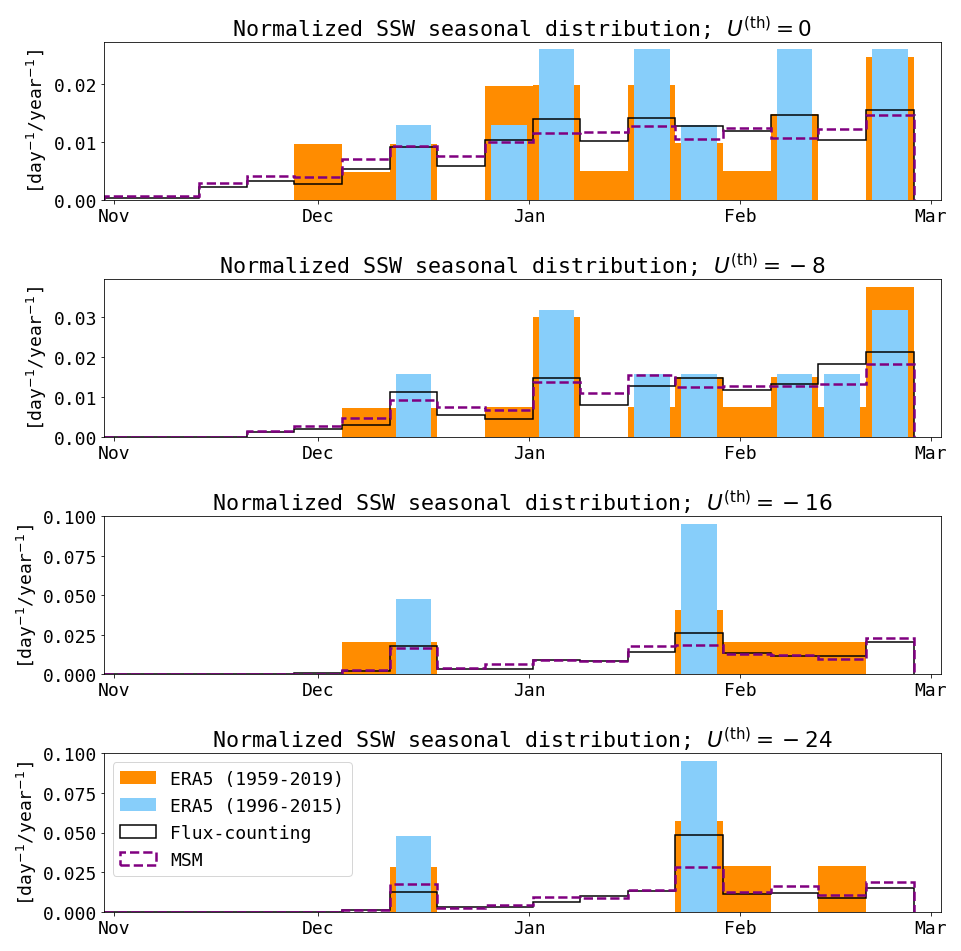

In [59]:
szn_dist_ssw = xr.DataArray(
    coords={"t_szn_cent": szn_stats_e5["t_szn_cent"], "src": ["s2","dga","e5_1996-2015","e5_1959-2019"], 
            "u_thresh": u_thresh_list},
    dims=["t_szn_cent","src","u_thresh"],
    data=np.nan
)
flux_per_window = xr.open_dataarray(
    join(filedict["results"]["pathcounting"], 
         f"flux_per_window_{t_thresh[0]}-{t_thresh[1]}.nc"))

idx_uth = [13,11,9,7]
fig,axes = plt.subplots(nrows=len(idx_uth),figsize=(15,4*len(idx_uth)),sharey=False,sharex=True,
                       gridspec_kw={"hspace": 0.5})
fig.set_facecolor("white")
i_ax = 0
for i_uth in idx_uth:
    uth = u_thresh_list[i_uth]
    dga_results = pickle.load(open(
        join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}", 
             f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{uth}"), "rb"))
    szn_dist_ssw.loc[dict(u_thresh=uth,src="dga")] = dga_results["flux_dens_tob"]
    szn_dist_ssw.loc[dict(u_thresh=uth,src="s2")] = flux_per_window.sel(u_thresh=uth,src="s2")
    szn_dist_ssw.loc[dict(u_thresh=uth,src="e5_1996-2015")] = flux_per_window.sel(u_thresh=uth,src="e5_1996-2015")
    szn_dist_ssw.loc[dict(u_thresh=uth,src="e5_1959-2019")] = flux_per_window.sel(u_thresh=uth,src="e5_1959-2019")
    
    ax = axes[i_ax]
    xticks,xticklabels = feat_strat.generate_seasonal_xticks(szn_dist_ssw.t_szn_cent.to_numpy())
    
    # Plot all the histograms
    bins = np.arange(t_thresh[0]-1,t_thresh[1]+4,7)
    hist,bin_edges,_ = ax.hist(
        szn_dist_ssw["t_szn_cent"],
        weights=szn_dist_ssw.sel(u_thresh=uth,src="e5_1959-2019").to_numpy(),
        bins=bins, density=True, histtype="barstacked", rwidth=1.0,
        edgecolor="none", facecolor="darkorange", 
        label="ERA5 (1959-2019)", 
    )
    hist,bin_edges,_ = ax.hist(
        szn_dist_ssw["t_szn_cent"],
        weights=szn_dist_ssw.sel(u_thresh=uth,src="e5_1996-2015").to_numpy(),
        bins=bins, density=True, histtype="barstacked", rwidth=0.75,
        edgecolor="none", facecolor="lightskyblue", 
        label="ERA5 (1996-2015)", 
    )
    hist,bin_edges,_ = ax.hist(
        szn_dist_ssw["t_szn_cent"],
        weights=szn_dist_ssw.sel(u_thresh=uth,src="s2").to_numpy(),
        bins=bins, density=True, histtype="step", 
        edgecolor="black", facecolor="none",
        label="Flux-counting", linewidth=1.5,
    )
    hist,bin_edges,_ = ax.hist(
        szn_dist_ssw["t_szn_cent"],
        weights=szn_dist_ssw.sel(u_thresh=uth,src="dga").to_numpy(),
        bins=bins, density=True, histtype="step", 
        edgecolor="purple", facecolor="none",  
        label="MSM", linewidth=2.5, linestyle="--"
    )
    
    if i_ax == len(axes)-1: ax.legend(loc="upper left",bbox_to_anchor=(0,1))
    ax.set_ylabel("[day$^{-1}$/year$^{-1}$]")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([t_thresh[0]-1, t_thresh[1]+2])
    if i_ax < len(axes): ax.set_xlabel("")
    ax.tick_params(which="both",labelbottom=True)
    ax.set_title(r"Normalized SSW seasonal distribution; $U^{\mathrm{(th)}}=%i$"%(uth))
    i_ax += 1
    
fig.savefig(join(filedict["results"]["dga"], f"cl{num_clusters}_md{max_delay}","szn_dist"))
    


In [48]:
msm_info["s2"].keys()

dict_keys(['idx_t_init', 'szn_window', 'szn_start_year', 'traj_beginning_flag', 'traj_ending_flag', 'km_centers', 'km_assignment', 'km_n_clusters', 'P_list', 'Nt_szn'])

In [49]:
dga_results["qp"]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.